In [32]:
import numpy as np
import json
import time
import datetime
from osgeo import gdal
import matplotlib.pyplot as plt
from area import area
import pickle
import geojson

from shapely import geometry, ops

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from pyproj import Proj
from scipy import ndimage, spatial
from scipy.signal import fftconvolve
from PIL import Image, ImageDraw
from matplotlib.collections import LineCollection
import pandas as pd

import shapefile
from shp_utils_py3 import *

In [11]:
def cut_line_at_points(line, points):

    # First coords of line
    coords = list(line.coords)

    # Keep list coords where to cut (cuts = 1)
    cuts = [0] * len(coords)
    cuts[0] = 1
    cuts[-1] = 1

    # Add the coords from the points
    coords += [list(p.coords)[0] for p in points]    
    cuts += [1] * len(points)        

    # Calculate the distance along the line for each point    
    dists = [line.project(geometry.Point(p)) for p in coords]    

    # sort the coords/cuts based on the distances    
    # see http://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list    
    coords = [p for (d, p) in sorted(zip(dists, coords))]    
    cuts = [p for (d, p) in sorted(zip(dists, cuts))]          

    # generate the Lines    
    #lines = [LineString([coords[i], coords[i+1]]) for i in range(len(coords)-1)]    
    lines = []        

    for i in range(len(coords)-1):    
        if cuts[i] == 1:    
            # find next element in cuts == 1 starting from index i + 1   
            j = cuts.index(1, i + 1)    
            lines.append(geometry.LineString(coords[i:j+1]))            

    return lines

In [14]:


# create three lines
line_a = geometry.LineString([[0,0], [3,3]])
line_b = geometry.LineString([[2,1], [2,3]])
#line_c = geometry.LineString([[1,0], [2,0]])

# combine them into a multi-linestring
multi_line = geometry.MultiLineString([line_a, line_b])
print(multi_line)  # prints MULTILINESTRING ((0 0, 1 1), (1 1, 2 2), (2 2, 3 3))

IntPoints=line_a.intersection(line_b)
print (IntPoints)

# you can now merge the lines
merged_line = ops.linemerge(multi_line)
print(merged_line)  # prints LINESTRING (0 0, 1 1, 2 2, 3 3)

splitsegs = cut_line_at_points(line_a, [IntPoints])
for s in splitsegs:
    print ('s',s)

MULTILINESTRING ((0 0, 3 3), (2 1, 2 3))
POINT (2 2)
MULTILINESTRING ((0 0, 3 3), (2 1, 2 3))
s LINESTRING (0 0, 2 2)
s LINESTRING (2 2, 3 3)


In [2]:
urban_centres = json.load(open('./data_layers/GHS_URBAN_CENTRES/GHS_urban_centres_shp.geojson','r'))

In [3]:
print (len(urban_centres['features']))

13135


In [5]:
for ft in urban_centres['features'][0:3]:
    print (ft['properties'].keys())

dict_keys(['ID_HDC_G0', 'QA2_1V', 'AREA', 'BBX_LATMN', 'BBX_LONMN', 'BBX_LATMX', 'BBX_LONMX', 'GCPNT_LAT', 'GCPNT_LON', 'CTR_MN_NM', 'CTR_MN_ISO', 'XBRDR', 'XCTR_NBR', 'XC_NM_LST', 'XC_ISO_LST', 'GRGN_L1', 'GRGN_L2', 'UC_NM_MN', 'UC_NM_LST', 'UC_NM_SRC', 'H75_NBR', 'H90_NBR', 'H00_NBR', 'H75_AREA', 'H90_AREA', 'H00_AREA', 'E_BM_NM_LS', 'E_SL_LST', 'EL_AV_ALS', 'E_KG_NM_LS', 'E_RB_NM_LS', 'E_WR_P_90', 'E_WR_P_00', 'E_WR_P_14', 'E_WR_T_90', 'E_WR_T_00', 'E_WR_T_14', 'B75', 'B90', 'B00', 'B15', 'P75', 'P90', 'P00', 'P15', 'BUCAP75', 'BUCAP90', 'BUCAP00', 'BUCAP15', 'NTL_AV', 'GDP90_SM', 'GDP00_SM', 'GDP15_SM', 'INCM_CMI', 'DEV_CMI', 'TT2CC', 'E_GR_AV90', 'E_GR_AV00', 'E_GR_AV14', 'E_GR_AH90', 'E_GR_AM90', 'E_GR_AL90', 'E_GR_AT90', 'E_GR_AH00', 'E_GR_AM00', 'E_GR_AL00', 'E_GR_AT00', 'E_GR_AH14', 'E_GR_AM14', 'E_GR_AL14', 'E_GR_AT14', 'E_EC2E_E75', 'E_EC2E_E90', 'E_EC2E_E00', 'E_EC2E_E12', 'E_EC2E_R75', 'E_EC2E_R90', 'E_EC2E_R00', 'E_EC2E_R12', 'E_EC2E_I75', 'E_EC2E_I90', 'E_EC2E_I00', 'E_E

127
iiP 80
iiP 88
iiP 91
iiP 93
iiP 94
iiP 97
iiP 98
iiP 99


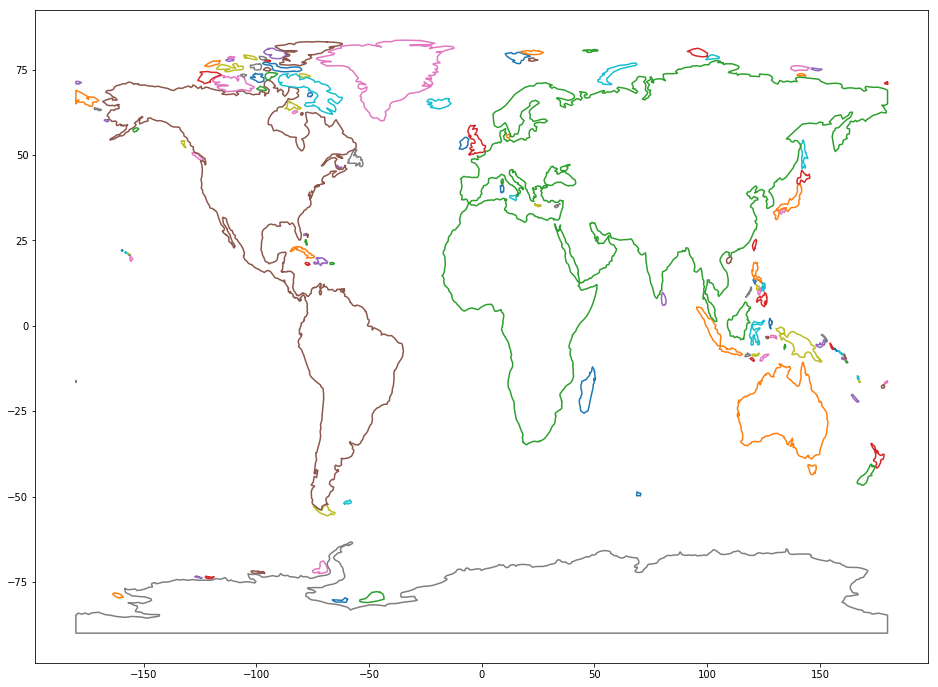

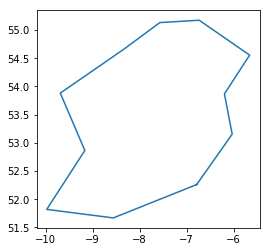

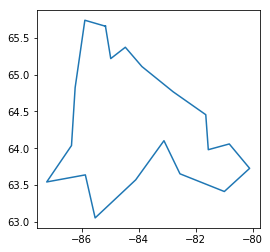

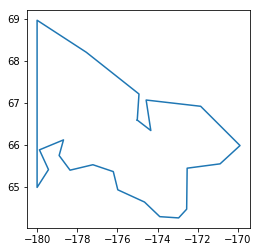

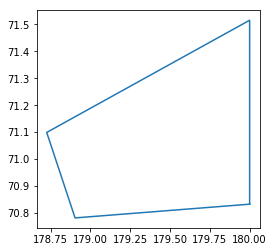

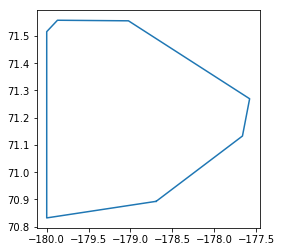

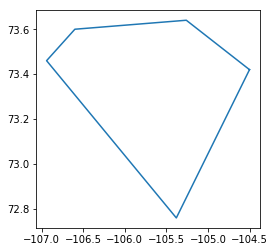

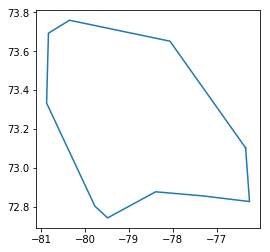

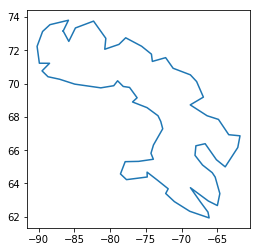

ii_p 126


In [45]:
coastline_json = json.load(open('./ne/ne_110m_land.geojson','r'))
coastline_polys = [geometry.Polygon(ft['geometry']['coordinates'][0]) for ft in coastline_json['features']]# if len(ft['geometry']['coordinates'])>2]
print (len(coastline_polys))

select_polys = [p for ii_p, p in enumerate(coastline_polys) if ii_p in [80,88,91,93,94,97,98,99]]
fig, axs = plt.subplots(1,1,figsize=(16,12))
for ii_p,p in enumerate(coastline_polys):

    xs, ys = p.exterior.xy
    axs.plot(xs,ys)
    if ii_p in [80,88,91,93,94,97,98,99]:
        fig2,axs2 = plt.subplots(1,1,figsize=(4,4))
        axs2.plot(xs,ys)
        print ('iiP',ii_p)
plt.show()
print ('ii_p',ii_p)

In [146]:
#dijkstra
def dijkstra_seapath(dep_lonlat, dest_lonlat, fname):
    """
    inputs: departure latlon; destination latlon; shoreline geojson
    outputs: waypoints for shortest route from dep to dest
    
    """
    
    def get_gc_linestring(pt1,pt2):
        dist, az_dep,dummy = V_inv((pt1.y,pt1.x), (pt2.y,pt2.x))
        print ('d,azaz',dist, az_dep, dummy)
        points = []
        points.append([pt1.x,pt1.y])
        
        for ii in range(1,int(dist/10.)):
            next_pt = V_dir((pt1.y,pt1.x),ii*10*1000.,az_dep)[0]
            points.append([next_pt[1],next_pt[0]])
        points.append([pt2.x,pt2.y])
        
        #print (points)
        return geometry.LineString(points)
    def gen_gc_linestring(pt1,az):
        points = []
        points.append([pt1.x, pt1.y])
        new_pt = V_dir((pt1.y,pt1.x),10000., az)[0]
        ii=1
        while np.abs(new_pt[0])<80. and ii<2000:
            #print (ii,new_pt[0])
            points.append([new_pt[1],new_pt[0]])
            new_pt = V_dir((pt1.y,pt1.x),ii*10*1000.,az)[0]
            ii+=1
        return geometry.LineString(points)
    
    fig, axs=plt.subplots(1,1,figsize=(16,12))
    
    coastline_json = json.load(open(fname,'r'))
    coastline_polys = [geometry.Polygon(ft['geometry']['coordinates'][0]) for ft in coastline_json['features']]# if len(ft['geometry']['coordinates'])>2]
    #print (len(coastline_polys))
    #print (coastline_polys[5].exterior.coords.xy)
    for p in coastline_polys:
        xs,ys =p.exterior.xy
        axs.plot(xs, ys, color='r')
    
    coastline_mp = geometry.MultiPolygon(coastline_polys)
    
    ### extend the shortest path until its reachable
    
    dep_pt = geometry.Point([dep_lonlat[0],dep_lonlat[1]])
    dest_pt = geometry.Point([dest_lonlat[0],dest_lonlat[1]])
    
    ls = get_gc_linestring(dep_pt, dest_pt)
    
    print ('int', ls.intersects(coastline_mp), ls.intersection(coastline_mp).type)
    
    if not ls.intersects(coastline_mp): #is reachable
        return ls
    else:
        fig2, axs2 = plt.subplots(1,1,figsize=(12,6))
        dists = []
        
        ### Generate Lotus
        for az in range(360):
            ls = gen_gc_linestring(dep_pt, az)
            if ls.intersects(coastline_mp):
                int_line = ls.intersection(coastline_mp)
                print (int_line.type)
            
                # Length along line that is closest to the point
                print(int_line.project(dep_pt))

                # Now combine with interpolated point on line
                nl = int_line.interpolate(int_line.project(dep_pt))
                print(nl)  # POINT (5 7)
                axs.scatter(nl.x,nl.y,color='k')
                dists.append(V_inv((nl.y,nl.x), (dep_pt.y,dep_pt.x))[0])
                
            else:
                final_pt=geometry.Point(ls.coords[-1])
                axs.scatter(final_pt.x, final_pt.y, color='k')
                dists.append(V_inv((final_pt.y,final_pt.x), (dep_pt.y,dep_pt.x))[0])
                
        axs2.plot(range(360),dists)
    
        #print ('int',ls.intersects(coastline_mp), ls.intersection(coastline_mp))
        #int_line = ls.intersection(coastline_mp)
        ## Length along line that is closest to the point
        #print(int_line.project(dep_pt))

        # Now combine with interpolated point on line
        #nl = int_line.interpolate(int_line.project(dep_pt))
        #print(nl)  # POINT (5 7)
        #axs.scatter(nl.x,nl.y,color='k')
        #if ls.intersection(coastline_mp).type=='MultiLineString':
        #    for ll in list(ls.intersection(coastline_mp)):
        #        xs, ys = ll.xy
        #        axs.plot(xs, ys, color='g')
        #else:
        #    xs, ys = ls.intersection(coastline_mp).xy
        #    axs.plot(xs, ys, color='g')


        axs.scatter(dep_pt.x, dep_pt.y)
        axs.scatter(dest_pt.x,dest_pt.y)
        xs,ys = ls.xy
        axs.plot(xs,ys)
        plt.show()

    
    
    ### get line
    
   
    #for ft in coastline_json['features']:
    #    print (ft['geometry']['type'], len(ft['geometry']['coordinates']))
    

d,azaz 6807.930788 44.93901870290934 95.87483193857872
int True LineString
MultiLineString
0.0
POINT (-80.203929 25.63957491983389)
MultiLineString
0.0
POINT (-80.1968675666312 25.65685539425207)
MultiLineString
0.0
POINT (-80.18906322442176 25.67595388727146)
MultiLineString
0.0
POINT (-80.18038662361644 25.69718693875294)
MultiLineString
0.0
POINT (-80.17067659182793 25.72094896370704)
MultiLineString
0.0
POINT (-80.15972816692138 25.74774153776892)
MultiLineString
0.0
POINT (-80.14727573842309 25.77821465291006)
MultiLineString
0.0
POINT (-80.13298142848329 25.81319515110913)
MultiLineString
0.0
POINT (-78.7973857731464 33.68501480363378)
MultiLineString
0.0
POINT (-78.58689963755393 33.83769654900571)
MultiLineString
0.0
POINT (-78.39301109859126 33.8820463225053)
MultiLineString
0.0
POINT (-78.2007214968299 33.90674342276821)
MultiLineString
0.0
POINT (-77.99174560506287 33.98181318805493)
MultiLineString
0.0
POINT (-77.72887679881582 34.21641548138207)
MultiLineString
0.0
POINT (

MultiLineString
0.0
POINT (-77.81429844937645 23.78778410394898)
MultiLineString
0.0
POINT (-72.25928328732734 19.81348740115559)
MultiLineString
0.0
POINT (-72.60575311822272 19.87338923222285)
MultiLineString
0.0
POINT (-72.88645721413512 19.89371718733281)
MultiLineString
0.0
POINT (-73.15453878680074 19.91313104788671)
MultiLineString
0.0
POINT (-73.27201628007006 19.81487563694794)
MultiLineString
0.0
POINT (-73.36725117934117 19.69811810929956)
MultiLineString
0.0
POINT (-74.35772216477517 20.38192748531291)
MultiLineString
0.0
POINT (-74.83200554771616 20.63873505985945)
MultiLineString
0.0
POINT (-75.07703793572365 20.70190262012342)
MultiLineString
0.0
POINT (-75.25734370540764 20.71197648611978)
MultiLineString
0.0
POINT (-75.79212815443377 21.08293144845632)
MultiLineString
0.0
POINT (-76.01227885656122 21.15821303115678)
MultiLineString
0.0
POINT (-76.21050331676582 21.21990229516696)
MultiLineString
0.0
POINT (-76.33976961116733 21.21450478566051)
MultiLineString
0.0
POINT

MultiLineString
0.0
POINT (-80.36504661168954 25.24529395424141)
MultiLineString
0.0
POINT (-80.36377318575546 25.24841023434035)
MultiLineString
0.0
POINT (-80.36253217523669 25.25144718865292)
MultiLineString
0.0
POINT (-80.36132163013308 25.25440958914623)
MultiLineString
0.0
POINT (-80.36013973120841 25.25730188778673)
MultiLineString
0.0
POINT (-80.35898477837596 25.26012824496281)
MultiLineString
0.0
POINT (-80.35785518026049 25.26289255502817)
MultiLineString
0.0
POINT (-80.35674944479793 25.26559846930593)
MultiLineString
0.0
POINT (-80.35566617075203 25.26824941684878)
MultiLineString
0.0
POINT (-80.35460404004291 25.27084862321227)
MultiLineString
0.0
POINT (-80.35356181079587 25.27339912746555)
MultiLineString
0.0
POINT (-80.35253831103016 25.27590379763586)
MultiLineString
0.0
POINT (-80.35153243291755 25.27836534475879)
MultiLineString
0.0
POINT (-80.35054312754885 25.28078633568552)
MultiLineString
0.0
POINT (-80.34956940015377 25.28316920478052)
MultiLineString
0.0
POINT

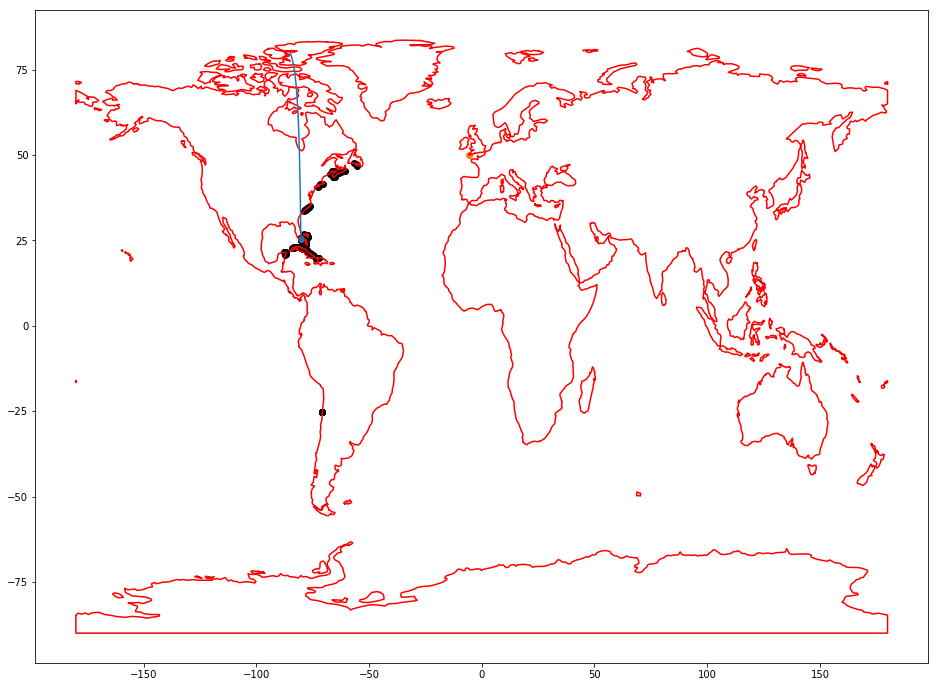

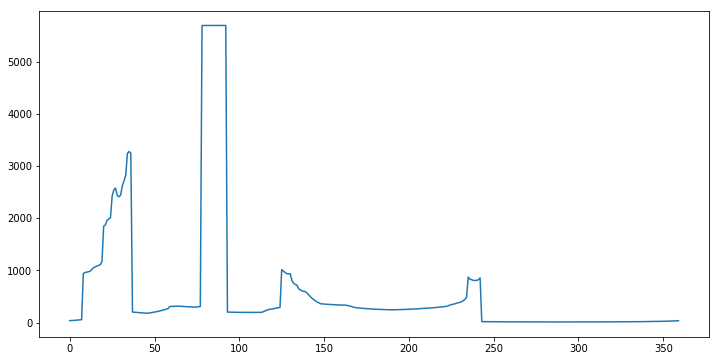

In [147]:
florida= [-80.203929,25.290189] 
UK= [-5.719479,50.122318] 
saudi = [45.944000,19.922252]
stjohns = [-52.563513,47.767986]
tokyo = [140.937652,35.700422]
SF = [ -123.108566,37.951163]
#unreachable: 53.223704, 0.387111

dijkstra_seapath(florida, UK,'./ne/ne_110m_land.geojson')

In [2]:
cities = pickle.load(open('all_cities.pickle','rb'))

In [4]:
pop_clusters = pickle.load(open('features_out.pickle','rb'))

In [11]:
for c in pop_clusters:
    c['properties'] = json.loads(c['properties'])

In [12]:
sum([c['properties']['area_clust'] for c in pop_clusters])

135043200.81827122

In [15]:
json.dump(geojson.FeatureCollection(pop_clusters), open('clusters_fc.geojson','w'))

### Compile shapefiles

In [ ]:
## in size order: 
#lng: 1.4mb
#fields: 156mb
#mines: 216mb
#pipelines: 607mb
#ports: 17mb
#processing_plants: 8mb
#rail: 1.2GB
#well_pads: 43mb

In [ ]:
#djikstra https://www3.cs.stonybrook.edu/~skiena/combinatorica/animations/dijkstra.html

In [15]:
meta = {}
meta['fields'] = {'path':'./data_layers/fields/fields.geojson','name':'Fields','color':'#6c0093'}
meta['lng'] = {'path':'./data_layers/lng/lng.geojson','name':'LNG','color':'#46beb1'}
meta['mines'] = {'path':'./data_layers/mines/mines.geojson','name':'Mines','color':'#6d2f03'}
meta['ports'] = {'path':'./data_layers/ports/ports.geojson','name':'Ports','color':'#7f5636'}
meta['pipelines'] = {'path':'./data_layers/pipelines/pipelines.geojson','name':'Pipelines','color':'#006400'}
meta['processing_plants'] = {'path':'./data_layers/processing_plants/processing_plants.geojson','name':'Processing Plants','color':'#be46a6'}
meta['railways'] = {'path':'./data_layers/railway/railways.geojson','name':'Railways','color':'#646464'}
meta['railways_osm'] = {'path':'./data_layers/railway/osm_railways.geojson','name':'Railways OSM','color':'#646464'}
meta['well_pads'] = {'path':'./data_layers/well_pads/well_pads.geojson','name':'Well Pads','color':'#001c49'}

In [16]:
#lng: 1.4mb
#ports: 17mb
#processing_plants: 8mb
#well_pads: 43mb

#fields: 156mb
#mines: 216mb
#pipelines: 607mb
#rail: 1.2GB
data = {}
for inf_type in meta.keys():
    print (inf_type)
    data[inf_type]=json.load(open(meta[inf_type]['path'],'r', encoding="ISO-8859-1"))
    print (list(set([ft['geometry']['type'] for ft in data[inf_type]['features']])))

fields
['Polygon', 'MultiPolygon']
lng
['Point']
mines
['Point']
ports
['Point']
pipelines
['MultiLineString', 'LineString']
processing_plants
['Point']
railways
['MultiLineString', 'LineString']
railways_osm
['LineString']
well_pads
['Point']


In [17]:
data['coal_mines'] = geojson.FeatureCollection([ft for ft in data['mines']['features'] if 'COAL' in str(ft['properties']['commodity']).upper()])
meta['coal_mines'] = {'path':None,'name':'Coal Mines','color':'#89163e'}

In [18]:
meta['coal_mines_oxeo'] = {'path':'./data_layers/mines/oxeo_assets_w_payments.geojson','name':'Coal Mines','color':'#89163e'}
data['coal_mines_oxeo'] = geojson.FeatureCollection([ft for ft in json.load(open(meta['coal_mines_oxeo']['path'],'r'))['features'] if ft['properties']['COAL']==1])

In [19]:
meta['shipping_routes'] = {'path':'./data_layers/shipping_lanes.geojson','name':'Shipping Routes','color':'#7f5636'}
data['shipping_routes'] = json.load(open(meta['shipping_routes']['path'],'r'))

In [21]:
meta['pop_clusters'] = {'path':'./data_layers/GHS_URBAN_CENTRES/GHS_urban_centres_shp.geojson','name':'Population Clusters','color':'#96C3E4'}
data['pop_clusters'] = json.load(open(meta['pop_clusters']['path'],'r'))

In [20]:
meta['refineries'] = {'path':'./data_layers/refineries.geojson','name':'Refineries','color':'#be46a6'}
data['refineries'] = json.load(open(meta['refineries']['path'],'r'))

In [22]:
countries = json.load(open('./ne_10m_admin_0_countries.geojson','r'))

In [30]:
meta['power_stations'] = {'name':'Power Stations','color':'#A5CE8E'}

In [33]:
ps_df = pd.read_csv('./data_layers/power_stations/global_power_plant_database.csv')

In [34]:
GPPD = ps_df.to_dict('records')

### Put them all on the same plot

In [37]:
print (len(data['pop_clusters']['features']))

13135


inf type: railways 280734
0.0 0
3.5620908048187965e-06 1
7.124181609637593e-06 2
0.1000021372544829 28074
0.1000056993452877 28075
0.10000926143609253 28076
0.20000071241816098 56147
0.2000042745089658 56148
0.2000078365997706 56149
0.30000284967264385 84221
0.30000641176344867 84222
0.3000099738542535 84223
0.40000142483632195 112294
0.40000498692712677 112295
0.4000085490179316 112296
0.5 140367
0.5000035620908048 140368
0.5000071241816096 140369
0.6000021372544829 168441
0.6000056993452877 168442
0.6000092614360926 168443
0.700000712418161 196514
0.7000042745089657 196515
0.7000078365997706 196516
0.8000028496726439 224588
0.8000064117634487 224589
0.8000099738542535 224590
0.900001424836322 252661
0.9000049869271267 252662
0.9000085490179316 252663
inf type: railways_osm 216074
0.0 0
4.6280440960041465e-06 1
9.256088192008293e-06 2
0.1000027768264576 21608
0.10000740487055361 21609
0.2000009256088192 43215
0.2000055536529152 43216
0.3000037024352768 64823
0.3000083304793728 64824
0

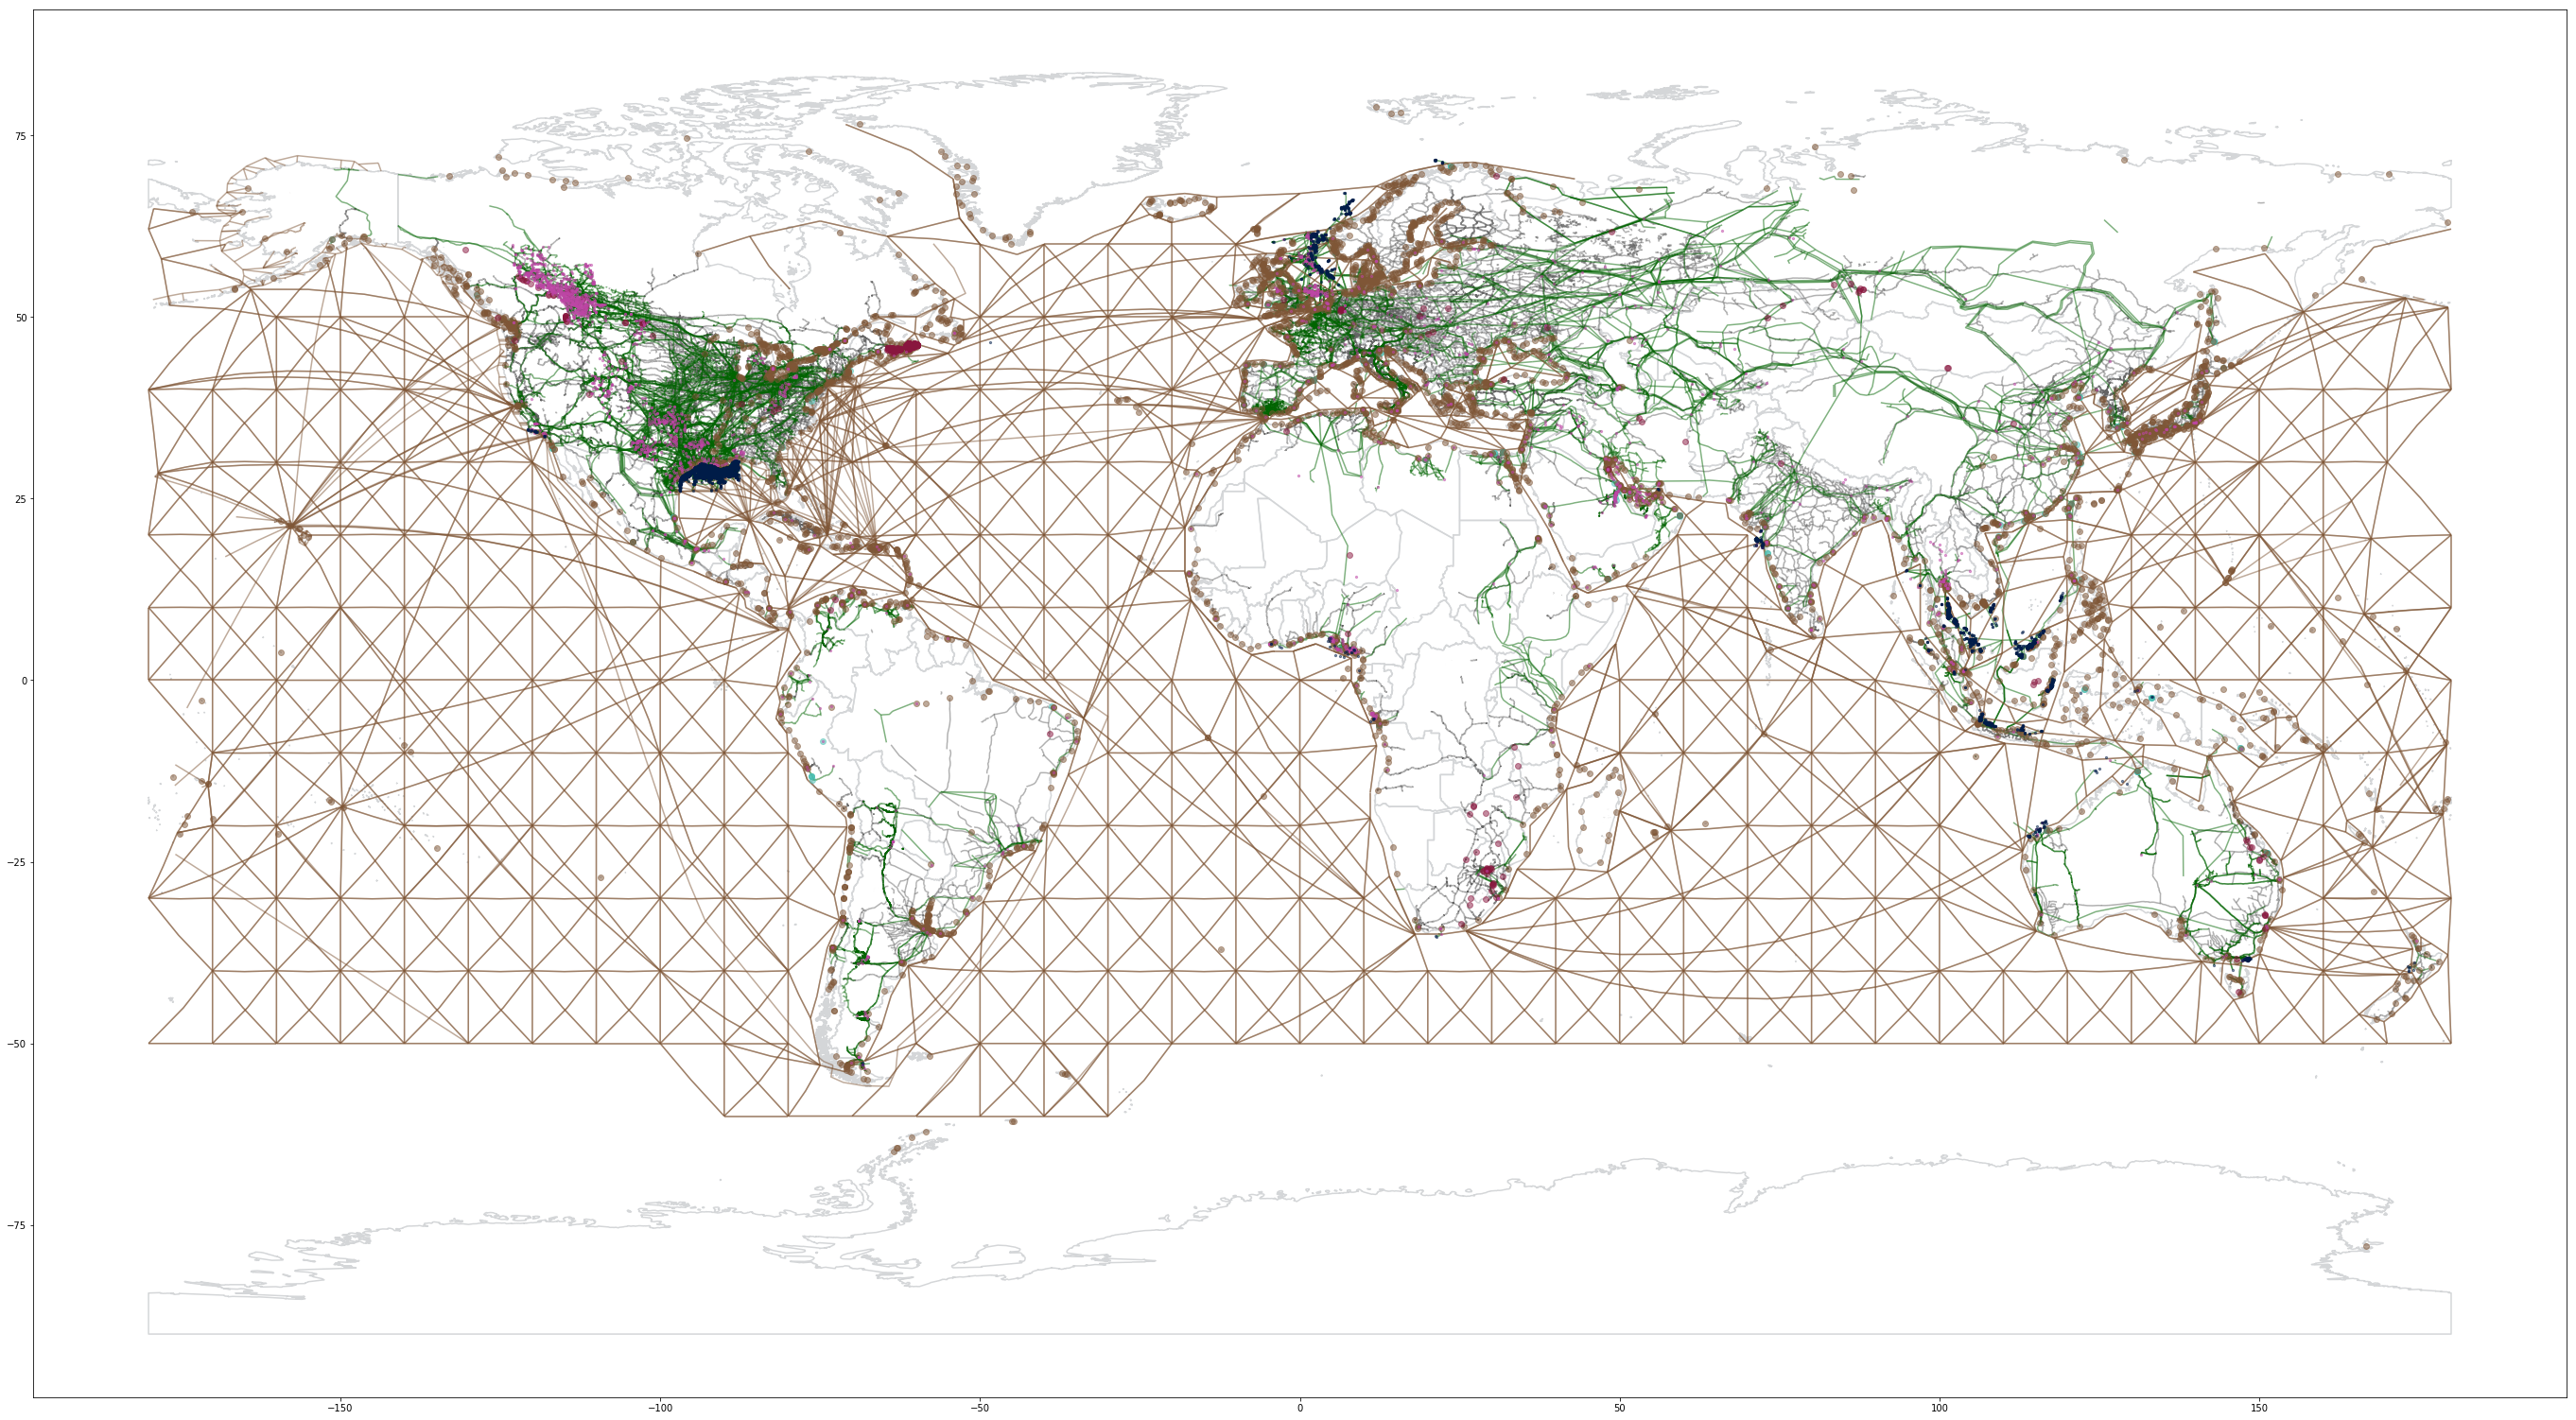

In [41]:
fig,axs = plt.subplots(1,1,figsize=(48,27))

for ft in countries['features']:
    country_shp = geometry.shape(ft['geometry'])
    if country_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)
    else:
        xs, ys = country_shp.exterior.xy
        axs.plot(xs, ys, color='#d4d6d8', zorder=1)
"""        
### do oil fields
for ii_f,ft in enumerate(data['fields']['features']):
    geo_shp = geometry.shape(ft['geometry'])
    if geo_shp.type=='MultiPolygon':
        for poly in list(geo_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color=meta['fields']['color'],alpha=0.5, zorder=2)
    else:
        xs, ys = geo_shp.exterior.xy
        axs.plot(xs, ys, color=meta['fields']['color'], alpha=0.5,zorder=2)
    if ii_f %5000==0:
        print ('fields',ii_f, ii_f/25000.)
"""
    
### do line collections
for inf_type in ['railways','railways_osm','pipelines','shipping_routes']:
    m = len(data[inf_type]['features'])
    print ('inf type:',inf_type,m)
    segments = []
    for ii_f,ft in enumerate(data[inf_type]['features']):
        geo_shp = geometry.shape(ft['geometry'])

        if geo_shp.type=='MultiLineString':
            for ll in list(geo_shp):
                segments.append(list(ll.coords))

        else:
            #print (dir(geo_shp.coords))
            #print (list(geo_shp.coords))
            segments.append(list(geo_shp.coords))

        if int(ii_f/m*100000) % 10000==0:
            print (ii_f/m, ii_f)

    #print (segments)

    line_segments = LineCollection(segments, color=meta[inf_type]['color'], alpha=0.5,zorder=3)
    axs.add_collection(line_segments)
    
for inf_type in ['lng','ports','coal_mines_oxeo', 'coal_mines']:


    xs = []
    ys = []
    for ft in data[inf_type]['features']:
        x,y = geometry.shape(ft['geometry']).xy
        xs.append(x)
        ys.append(y)
    axs.scatter(xs,ys,color=meta[inf_type]['color'],alpha=0.5, zorder=4)
    print (inf_type, len(xs))
    
for inf_type in ['processing_plants','refineries','well_pads']:


    xs = []
    ys = []
    for ft in data[inf_type]['features']:
        x,y = geometry.shape(ft['geometry']).xy
        xs.append(x)
        ys.append(y)
    axs.scatter(xs,ys,color=meta[inf_type]['color'],alpha=0.5,s=5, zorder=4)
    print (inf_type, len(xs))

"""
### do PSs
xs, ys = [],[]
for ii_f,ft in enumerate(GPPD):
    if (ft['fuel1'] in ['Oil','Gas','Coal'] and ft['longitude']<180 and ft['longitude']>-180 and ft['latitude']<89 and ft['latitude']>-89):
        pt = geometry.Point([ft['longitude'],ft['latitude']])
        xs.append(pt.x)
        ys.append(pt.y)

    if ii_f%1000==0:
        print (ii_f)
    #axs.scatter(pt.x, pt.y, color=cols_dict[ft['fuel1']], s=np.log(ft['capacity_mw']), zorder=2)

axs.scatter(xs, ys, color=meta['power_stations']['color'], alpha=0.5,s=5, zorder=5)

### do pop clusters
for ii_f,ft in enumerate(data['pop_clusters']['features']):
    geo_shp = geometry.shape(ft['geometry'])
    if geo_shp.type=='MultiPolygon':
        for poly in list(geo_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color=meta['pop_clusters']['color'],alpha=0.5, zorder=5)
    else:
        xs, ys = geo_shp.exterior.xy
        axs.plot(xs, ys, color=meta['pop_clusters']['color'], alpha=0.5,zorder=5)
    if ii_f %5000==0:
        print ('pop_clusters',ii_f)

"""
plt.show()

### Plot out some datasets

refineries 579


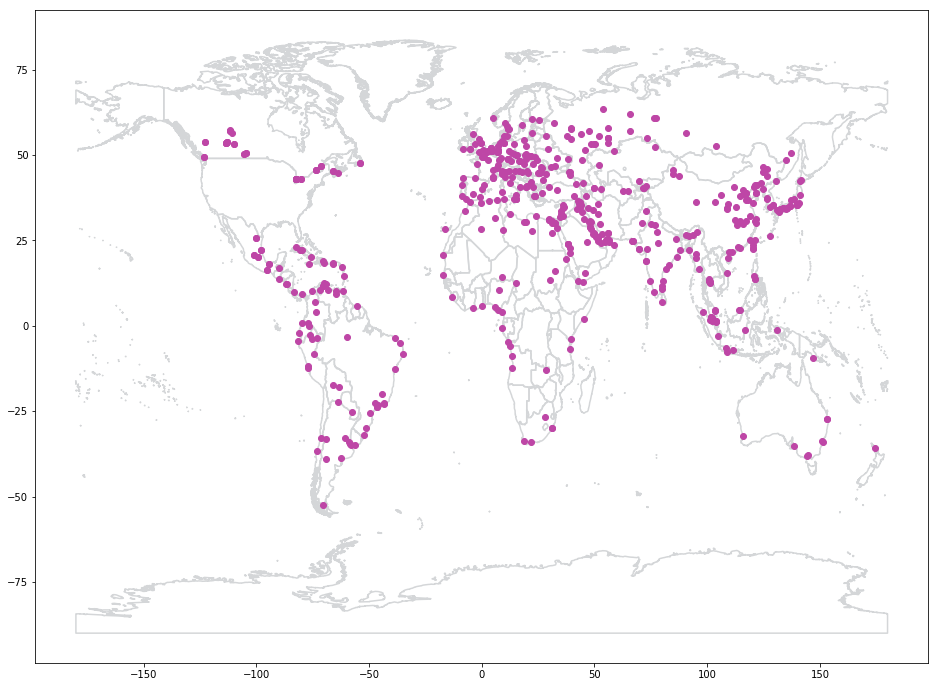

In [103]:
for inf_type in ['refineries']:

    fig,axs = plt.subplots(1,1,figsize=(32,18))

    for ft in countries['features']:
        country_shp = geometry.shape(ft['geometry'])
        if country_shp.type=='MultiPolygon':
            for poly in list(country_shp):
                xs,ys = poly.exterior.xy
                axs.plot(xs, ys, color='#d4d6d8', zorder=1)
        else:
            xs, ys = country_shp.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)



    xs = []
    ys = []
    for ft in data[inf_type]['features']:
        x,y = geometry.shape(ft['geometry']).xy
        xs.append(x)
        ys.append(y)
    axs.scatter(xs,ys,color=meta[inf_type]['color'], zorder=2)
    print (inf_type, len(xs))
    plt.show()

lng 329


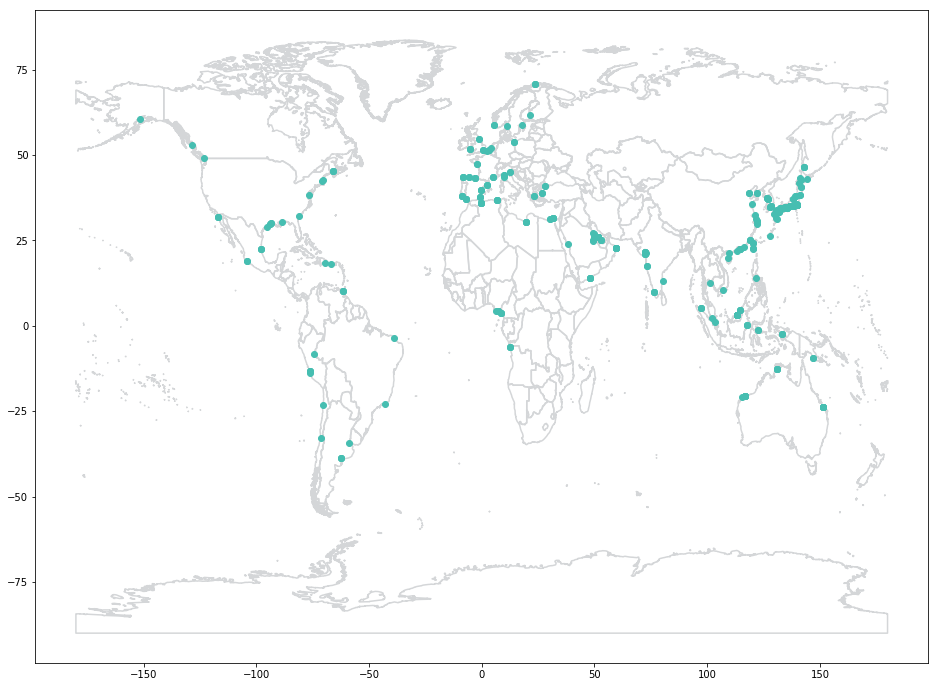

ports 3702


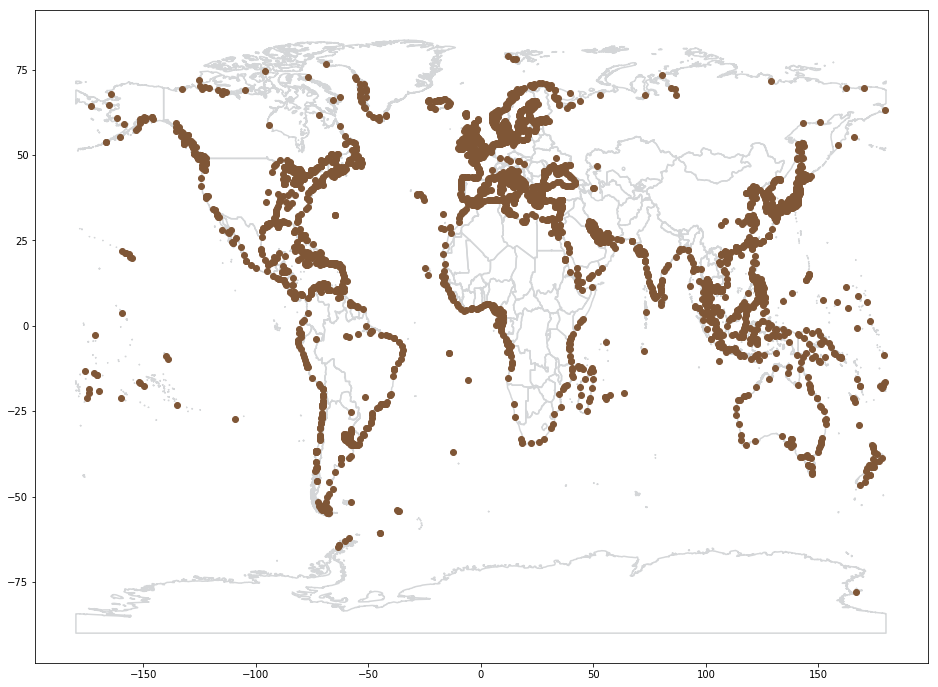

processing_plants 1922


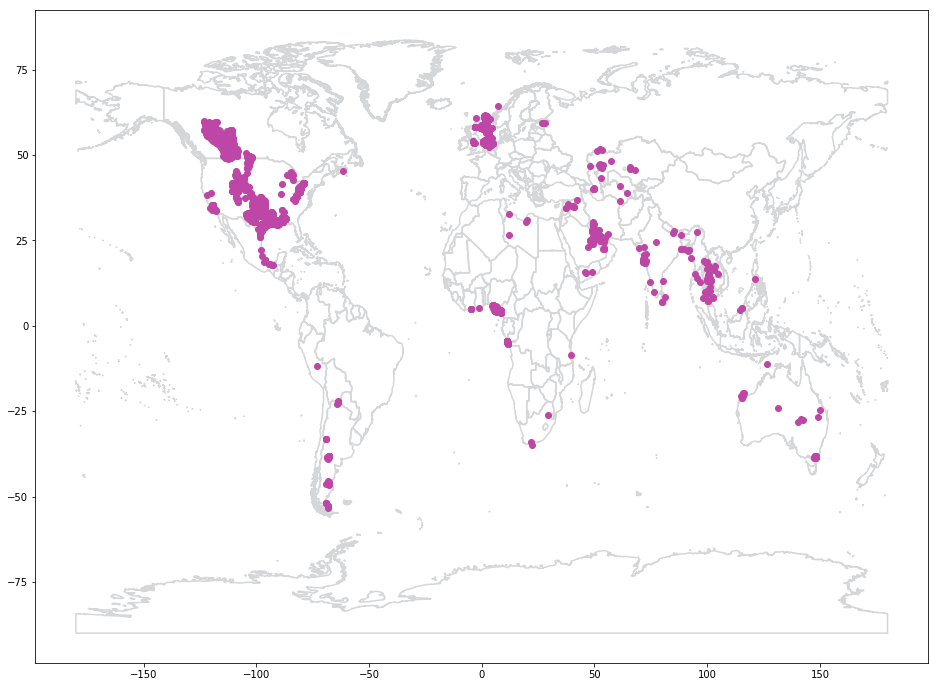

well_pads 9845


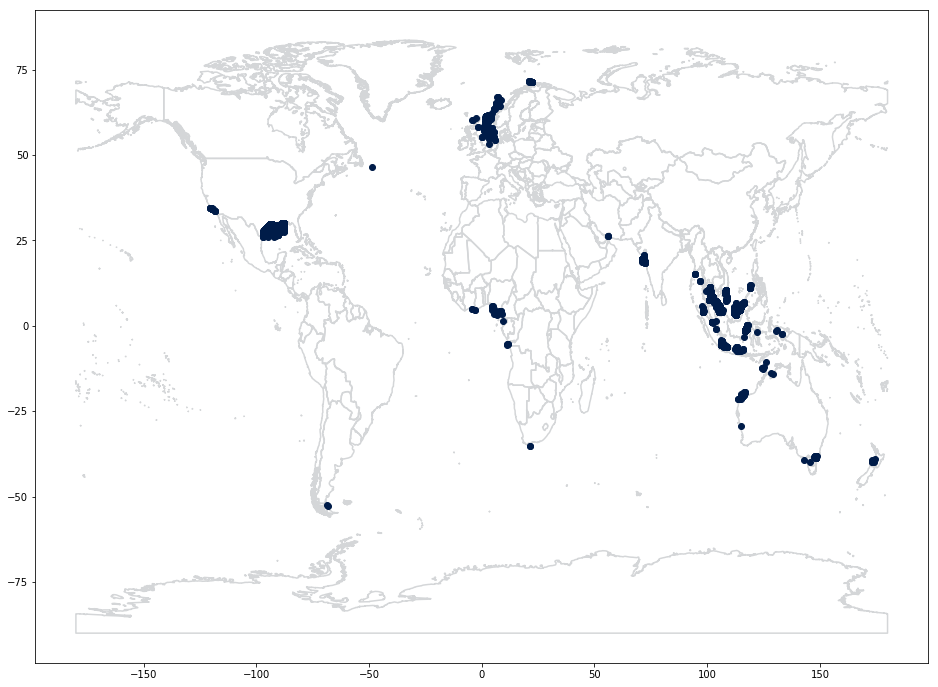

coal_mines_oxeo 84


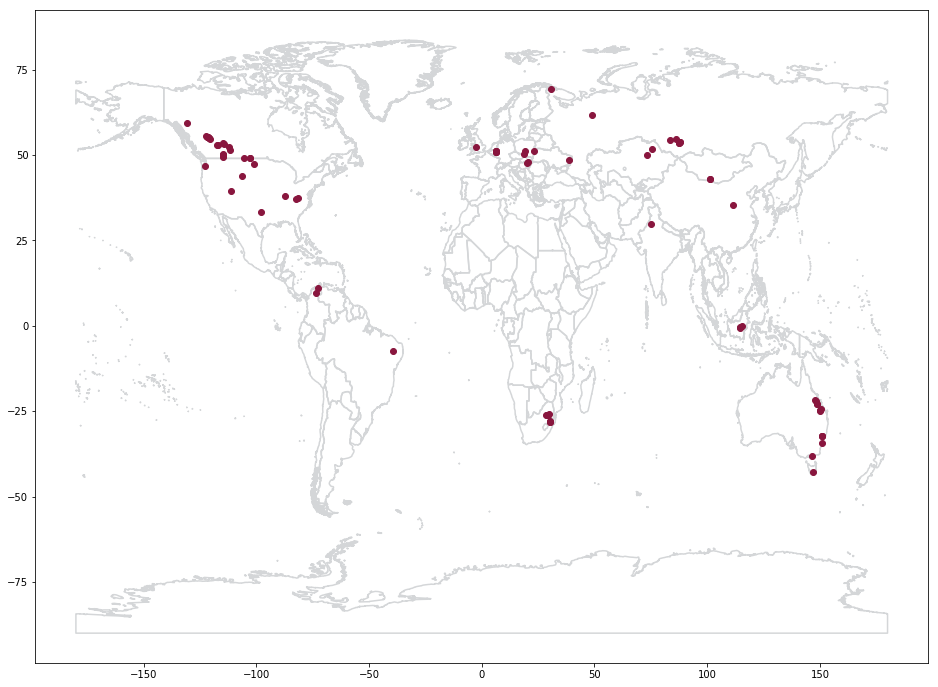

In [12]:
for inf_type in ['lng','ports','processing_plants','well_pads','coal_mines_oxeo']:

    fig,axs = plt.subplots(1,1,figsize=(16,12))

    for ft in countries['features']:
        country_shp = geometry.shape(ft['geometry'])
        if country_shp.type=='MultiPolygon':
            for poly in list(country_shp):
                xs,ys = poly.exterior.xy
                axs.plot(xs, ys, color='#d4d6d8', zorder=1)
        else:
            xs, ys = country_shp.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)




    plt.show()

In [43]:
meta['cities'] = {'path':'./all_cities.geojson','name':'Cities','color':'#96C3E4'}
data['cities'] = json.load(open(meta['cities']['path'],'r'))

In [46]:
print (len(data['cities']['features']), len(data['pop_clusters']['features']))

614 248


In [47]:
for ft in data['cities']['features']:
    print (ft['geometry']['type'])

Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon


pop_clusters 36


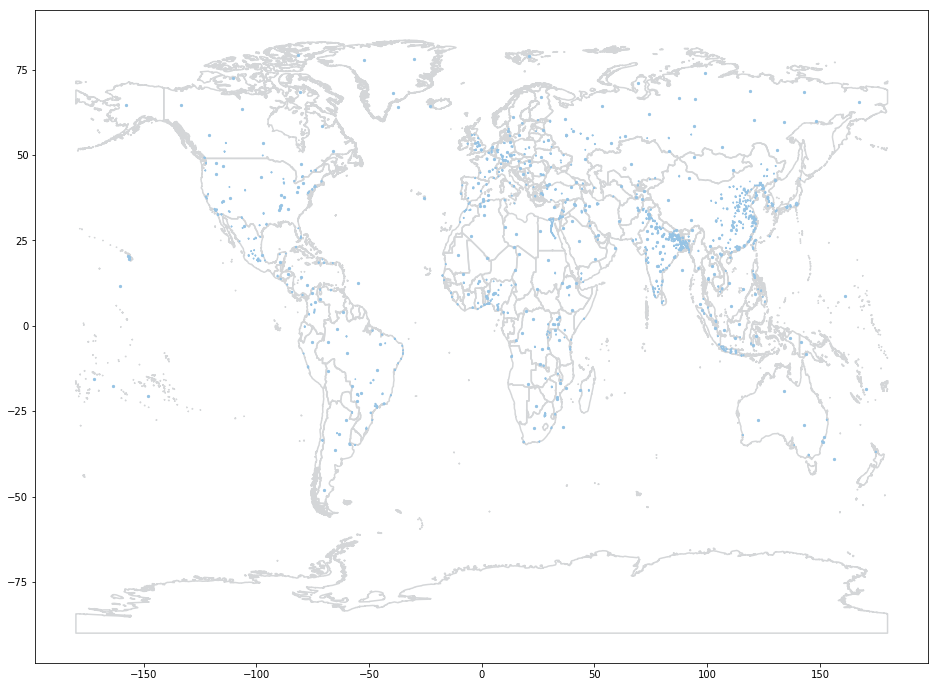

In [49]:
fig,axs = plt.subplots(1,1,figsize=(16,12))

for ft in countries['features']:
    country_shp = geometry.shape(ft['geometry'])
    if country_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)
    else:
        xs, ys = country_shp.exterior.xy
        axs.plot(xs, ys, color='#d4d6d8', zorder=1)



xs = []
ys = []
for ft in data[inf_type]['features']:
    x,y = geometry.shape(ft['geometry']).xy
    xs.append(x)
    ys.append(y)
axs.scatter(xs,ys,color=meta[inf_type]['color'], s=5,zorder=2)
    
    

for ft in data['cities']['features']:
    geo_shp = geometry.shape(ft['geometry'])
    if geo_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color=meta['cities']['color'], zorder=2)
    else:
        xs, ys = geo_shp.exterior.xy
        axs.plot(xs, ys, color=meta['cities']['color'], zorder=2)
print (inf_type, len(xs))
plt.show()
    

coal_mines_oxeo 2056


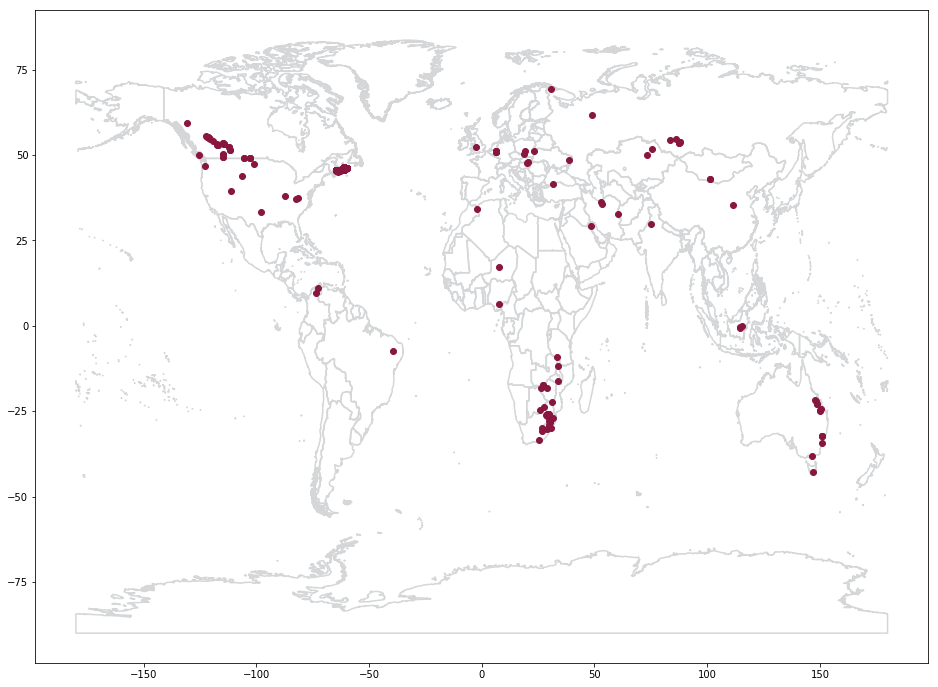

In [13]:
select_coalmines = data['coal_mines']['features']+data['coal_mines_oxeo']['features']

fig,axs = plt.subplots(1,1,figsize=(16,12))

for ft in countries['features']:
    country_shp = geometry.shape(ft['geometry'])
    if country_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)
    else:
        xs, ys = country_shp.exterior.xy
        axs.plot(xs, ys, color='#d4d6d8', zorder=1)



xs = []
ys = []
for ft in select_coalmines:
    x,y = geometry.shape(ft['geometry']).xy
    xs.append(x)
    ys.append(y)
axs.scatter(xs,ys,color=meta['coal_mines']['color'], zorder=2)
print (inf_type, len(xs))
plt.show()

lng 329
ports 3702
processing_plants 1922
well_pads 9845
coal_mines_oxeo 84


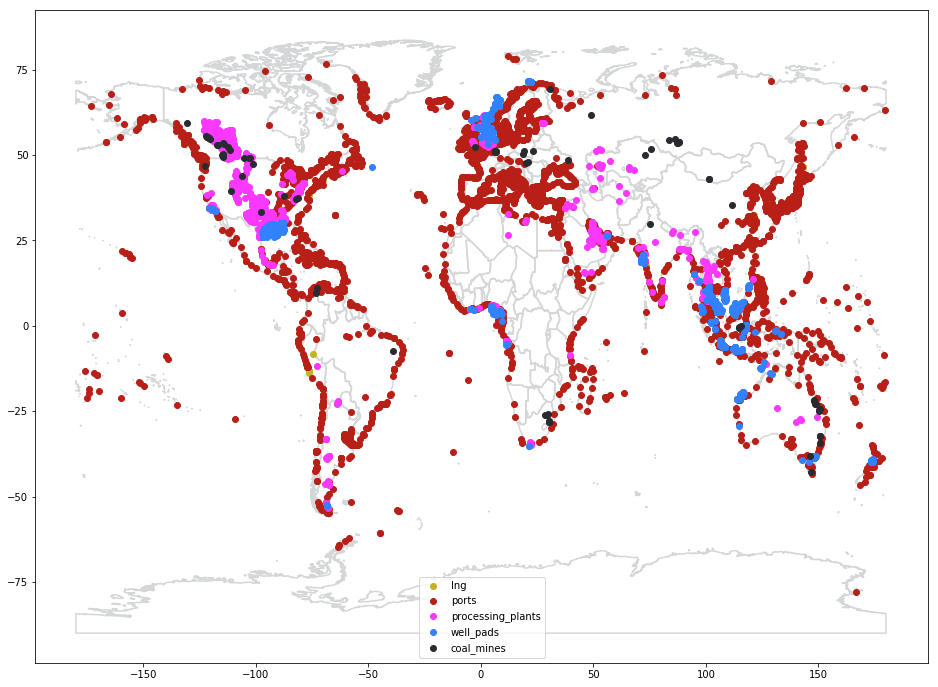

In [41]:
fig,axs = plt.subplots(1,1,figsize=(16,12))
handles = []

for ft in countries['features']:
    country_shp = geometry.shape(ft['geometry'])
    if country_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)
    else:
        xs, ys = country_shp.exterior.xy
        axs.plot(xs, ys, color='#d4d6d8', zorder=1)


for inf_type in ['lng','ports','processing_plants','well_pads','coal_mines_oxeo']:
    xs = []
    ys = []
    for ft in data[inf_type]['features']:
        x,y = geometry.shape(ft['geometry']).xy
        xs.append(x)
        ys.append(y)
    handles.append(axs.scatter(xs,ys,color=meta[inf_type]['color'], zorder=2))
    print (inf_type, len(xs))
    
axs.legend(handles, ['lng','ports','processing_plants','well_pads','coal_mines'])
plt.show()

In [11]:
from matplotlib.collections import LineCollection

In [9]:
CA_rail = json.load(open('./CA_railway.geojson','r'))

280734 216074
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000


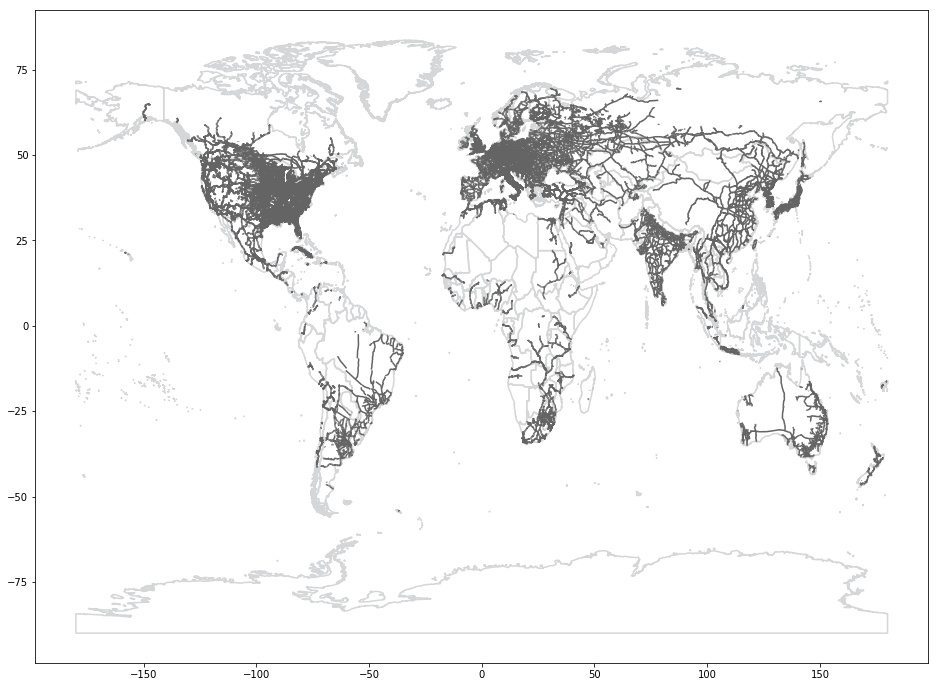

In [8]:
fig, axs = plt.subplots(1,1,figsize=(16,12))

print (len(data['railways']['features']), len(data['railways_osm']['features']))

segments = []

for ft in countries['features']:
    country_shp = geometry.shape(ft['geometry'])
    if country_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)
    else:
        xs, ys = country_shp.exterior.xy
        axs.plot(xs, ys, color='#d4d6d8', zorder=1)


for ii_f,ft in enumerate(data['railways']['features']+data['railways_osm']['features']):
    geo_shp = geometry.shape(ft['geometry'])
    
    if geo_shp.type=='MultiLineString':
        for ll in list(geo_shp):
            segments.append(list(ll.coords))

    else:
        #print (dir(geo_shp.coords))
        #print (list(geo_shp.coords))
        segments.append(list(geo_shp.coords))
    
    if ii_f % 5000==0:
        print (ii_f)
        
#print (segments)

line_segments = LineCollection(segments, color=meta[inf_type]['color'])
axs.add_collection(line_segments)
axs.autoscale()
               
plt.show()

25236
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000


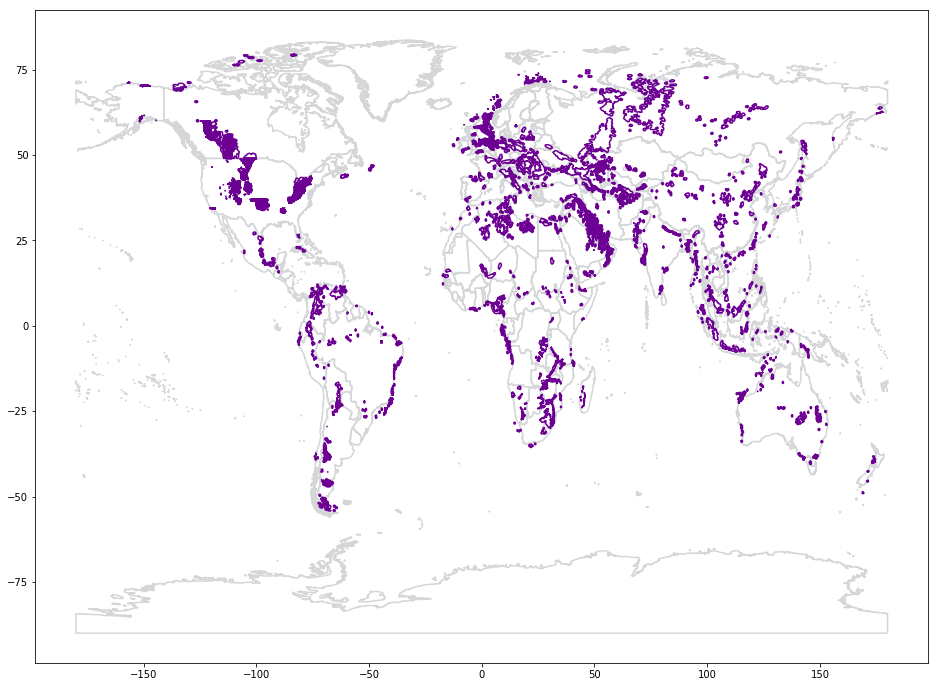

In [19]:
fig, axs = plt.subplots(1,1,figsize=(16,12))

print (len(data['fields']['features']))

for ft in countries['features']:
    country_shp = geometry.shape(ft['geometry'])
    if country_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)
    else:
        xs, ys = country_shp.exterior.xy
        axs.plot(xs, ys, color='#d4d6d8', zorder=1)


for ii_f,ft in enumerate(data['fields']['features']):
    geo_shp = geometry.shape(ft['geometry'])
    if geo_shp.type=='MultiPolygon':
        for poly in list(geo_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color=meta['fields']['color'], zorder=2)
    else:
        xs, ys = geo_shp.exterior.xy
        axs.plot(xs, ys, color=meta['fields']['color'], zorder=2)
    if ii_f %5000==0:
        print ('fields',ii_f, ii_f/25000.)
               
plt.show()

### Investigate Properties

In [104]:
inf_type = 'refineries'

all_properties = []
for ft in data[inf_type]['features']:
    all_properties+= ft['properties'].keys()


print (list(set(all_properties)))
print(data[inf_type]['features'][0])
print(len(data[inf_type]['features']))

['Type', 'Capacity', 'Sour_Ranks', 'MD_Region', 'Status', 'Operator', 'Onshore_Offshore', 'MD_Spatial_Data_Quality', 'MD_Fkey', 'Commodity', 'MD_Source', 'Installation_Date', 'MD_Source_Data_Quality', 'MD_Aquired_by', 'MD_Country', 'Facility_Name', 'MD_GAIA_Location', 'NumberSources', 'MD_Source_Date', 'Temp_Ranks', 'MD_Temporal_Data_Quality', 'Spat_Ranks']
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [19.757285000687194, 40.603915999443956]}, 'properties': {'MD_Country': 'Albania', 'MD_Source_Date': '', 'MD_Source': 'http://www.industryabout.com/world-fossil-fuels-energy-map', 'MD_Aquired_by': 'Devin Justman, Lucy Romeo', 'Onshore_Offshore': 'Onshore', 'Capacity': None, 'Operator': ' Albanian Refining &amp; Marketing of Oil sh.a (ARMO)', 'Installation_Date': '1978', 'Facility_Name': None, 'Status': None, 'Type': ' Oil Refinery', 'Commodity': ' Virgin Naphtha; Kerosene; Gasoil; Gasoline; Heavy fuel oil (solar; mazut and long residue); Petroleum Coke; Sulphur; Fuel o

In [107]:
for pp in ['Status', 'Operator','Type', 'Capacity','Commodity']:
    print(pp, len([ft for ft in data[inf_type]['features'] if ft['properties'][pp]!=None])/len(data[inf_type]['features']))

Status 0.0
Operator 1.0
Type 1.0
Capacity 0.0
Commodity 0.9533678756476683


In [108]:
for pp in ['Status', 'Operator','Type', 'Capacity','Commodity']:
    print (list(set([ft['properties'][pp] for ft in data[inf_type]['features']])))

[None]
[' YPFB Refinación S.A.', ' Total UK Limited', ' Indian Oil Corporation Ltd (IOCL)', ' Lanzhou Petrochemical Co Ltd', ' OJSC Achinsk Refinery', ' Bangchak Petroleum Plc', ' West Indies Oil Company Limited (WIOC)', ' JSC Ufaneftekhim Refinery', ' LLC RN-Tuapse Refinery', ' Saudi Aramco Mobil Refinery Company Ltd (SAMREF)', ' Moose Jaw Refinery (MJR)', ' North Refineries Company (NRC)', ' OJSC Novokuibyshevsk Refinery', ' Irving Oil Limited', ' Pearl GTL', ' Česká rafinérská as (CRC)', ' JSC Orsknefteorgsintez', ' Sinopec Beijing Yanshan Petrochemical Company (BYPC)', ' Petron Oil and Gas International', ' SC Petrotel Lukoil SA', ' Sinopec Tianjin Company (TPCC)', ' Panipat Refinery', ' JSC Kyrgyz Petroleum Co (KPC)', ' The Abu Dhabi Oil Refining Company (TAKREER)', ' Sinopec Jinling Company', 'Suncor Oil Sands Group', ' BP Oil Refinería de Castellón SAU', ' Raffineria di Venezia-Porto Marghera', ' Yacimientos Petrolíferos Fiscales SA (YPF)', ' Warri Refining &amp; Petrochemical C

In [53]:
from osgeo import ogr
driver = ogr.GetDriverByName("OpenFileGDB")
print (driver)

<osgeo.ogr.Driver; proxy of <Swig Object of type 'OGRDriverShadow *' at 0x7f942933dbd0> >


In [60]:
print(dir(driver))
ds = driver.Open('./data_layers/GOGI_V10.gdb',0)
print(ds)


['CopyDataSource', 'CreateDataSource', 'DeleteDataSource', 'Deregister', 'GetDescription', 'GetMetadata', 'GetMetadataDomainList', 'GetMetadataItem', 'GetMetadata_Dict', 'GetMetadata_List', 'GetName', 'Open', 'Register', 'SetDescription', 'SetMetadata', 'SetMetadataItem', 'TestCapability', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_s', 'name', 'this']
<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x7f942d4f8d20> >


In [63]:
refineries = ds.GetLayer('refineries')

In [89]:
sr = refineries.GetSpatialRef()

In [94]:
reproj = Proj(sr.ExportToProj4())

In [100]:
features= []

print (dir(refineries))
print (refineries.GetFeatureCount())
print (dir(refineries.GetFeature(1)))
print (refineries.GetFeature(1).ExportToJson())

for ii in range(1,refineries.GetFeatureCount()):
    #print (ii)
    if refineries.GetFeature(ii) is not None:
        print (ii)
        inp_ft = json.loads(refineries.GetFeature(ii).ExportToJson())
        pt_inp = geometry.shape(inp_ft['geometry'])
        lon, lat= reproj(pt_inp.x,pt_inp.y, inverse=True)
        
        
        features.append(geojson.Feature(
            geometry=geometry.Point(lon,lat),
            properties=inp_ft['properties']))
    
print (len(features))

['AlterFieldDefn', 'Clip', 'CommitTransaction', 'CreateFeature', 'CreateField', 'CreateFields', 'CreateGeomField', 'DeleteFeature', 'DeleteField', 'Dereference', 'Erase', 'FindFieldIndex', 'GetDescription', 'GetExtent', 'GetFIDColumn', 'GetFeature', 'GetFeatureCount', 'GetFeaturesRead', 'GetGeomType', 'GetGeometryColumn', 'GetLayerDefn', 'GetMetadata', 'GetMetadataDomainList', 'GetMetadataItem', 'GetMetadata_Dict', 'GetMetadata_List', 'GetName', 'GetNextFeature', 'GetRefCount', 'GetSpatialFilter', 'GetSpatialRef', 'GetStyleTable', 'Identity', 'Intersection', 'Reference', 'ReorderField', 'ReorderFields', 'ResetReading', 'RollbackTransaction', 'SetAttributeFilter', 'SetDescription', 'SetFeature', 'SetIgnoredFields', 'SetMetadata', 'SetMetadataItem', 'SetNextByIndex', 'SetSpatialFilter', 'SetSpatialFilterRect', 'SetStyleTable', 'StartTransaction', 'SymDifference', 'SyncToDisk', 'TestCapability', 'Union', 'Update', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '

In [101]:
json.dump(geojson.FeatureCollection(features), open('./data_layers/refineries.geojson','w'))

### do power stations

In [45]:
import pandas as pd

In [46]:
ps_df = pd.read_csv('./data_layers/power_stations/global_power_plant_database.csv')

In [50]:
cols_dict = {'Hydro':'blue', 
             'Gas':'darkgray',  
             'Oil':'dimgray', 
             'Wind':'cyan', 
             'Nuclear':'purple', 
             'Coal':'k', 
             'Solar':'gold',
             'Waste':'salmon', 
             'Biomass':'darkgreen', 
             'Wave and Tidal':'springgreen', 
             'Geothermal':'r', 
             'Cogeneration':'brown', 
             'Storage':'orchid', 
             'Petcoke':'k'}

In [52]:
df_dicts = ps_df.to_dict('records')

In [79]:
list(ps_df)

['country',
 'country_long',
 'name',
 'gppd_idnr',
 'capacity_mw',
 'latitude',
 'longitude',
 'fuel1',
 'fuel2',
 'fuel3',
 'fuel4',
 'commissioning_year',
 'owner',
 'source',
 'url',
 'geolocation_source',
 'year_of_capacity_data',
 'generation_gwh_2013',
 'generation_gwh_2014',
 'generation_gwh_2015',
 'generation_gwh_2016',
 'estimated_generation_gwh']

In [80]:
np.sum(pd.isnull(ps_df.commissioning_year))

13712

In [62]:
from matplotlib.lines import Line2D

28664
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


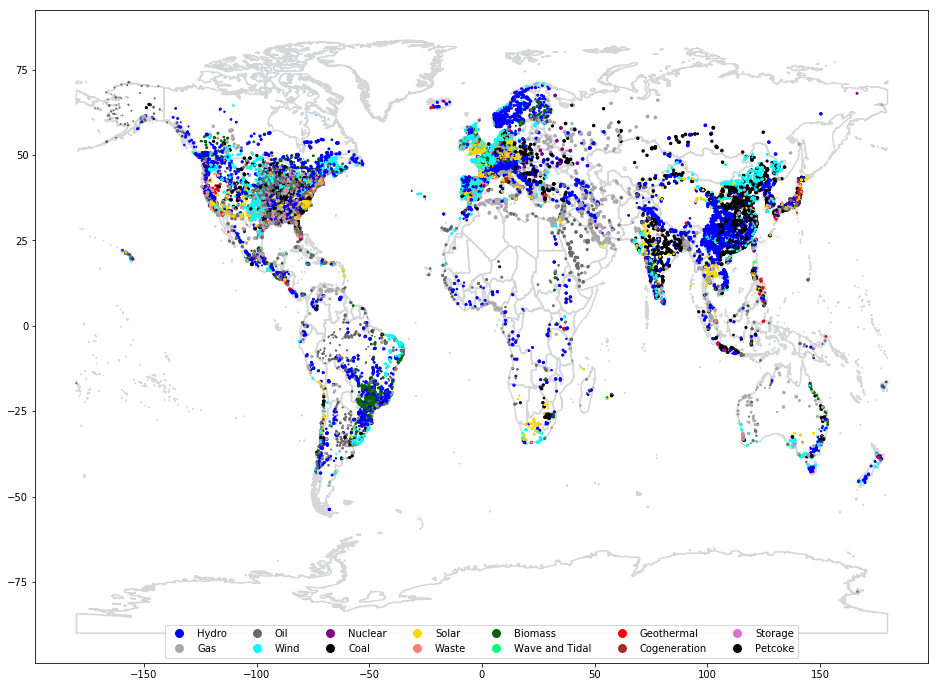

In [65]:
fig, axs = plt.subplots(1,1,figsize=(16,12))

print (len(df_dicts))

for ft in countries['features']:
    country_shp = geometry.shape(ft['geometry'])
    if country_shp.type=='MultiPolygon':
        for poly in list(country_shp):
            xs,ys = poly.exterior.xy
            axs.plot(xs, ys, color='#d4d6d8', zorder=1)
    else:
        xs, ys = country_shp.exterior.xy
        axs.plot(xs, ys, color='#d4d6d8', zorder=1)

xs, ys = [],[]
colors_list = []
sizes_list = []
for ii_f,ft in enumerate(df_dicts):
    if (ft['fuel1'] in cols_dict.keys() and ft['longitude']<180 and ft['longitude']>-180 and ft['latitude']<89 and ft['latitude']>-89):
        pt = geometry.Point([ft['longitude'],ft['latitude']])
        xs.append(pt.x)
        ys.append(pt.y)
        colors_list.append(cols_dict[ft['fuel1']])
        sizes_list.append(np.log(ft['capacity_mw']))
    if ii_f%1000==0:
        print (ii_f)
    #axs.scatter(pt.x, pt.y, color=cols_dict[ft['fuel1']], s=np.log(ft['capacity_mw']), zorder=2)
    
legend_elements=[]
for k,v in cols_dict.items():
    legend_elements.append(Line2D([0],[0],marker='o',color='w',label=k,markerfacecolor=v,markersize=10))
    

axs.scatter(xs, ys, color=colors_list, s=sizes_list, zorder=2)
axs.legend(handles=legend_elements, ncol=7, loc='lower center')
               
plt.show()

### inspect mines

In [2]:
mines = json.load(open('./mines/mines.geojson','r'))

In [3]:
print (len(mines['features']))
print (mines['features'][0])

51602
{'type': 'Feature', 'properties': {'md_country': 'Canada', 'md_source_': '5/3/2016', 'md_source': 'https://gesner.novascotia.ca/amosearch/singlereport.aspx?ShaftID=BKC-1-001', 'onshore_of': 'Onshore', 'capacity': None, 'operator': None, 'installati': None, 'facility_n': None, 'status': 'Not Rated', 'type': 'COAL', 'commodity': 'COAL', 'md_fkey': '177', 'spat_ranks': '4.0; 4.0; 4.0', 'temp_ranks': '4.0; 4.0; 5.0', 'sour_ranks': '5.0; 5.0; 5.0', 'md_region': 'N. and C. America', 'md_source0': 5.0, 'md_tempora': 4.3, 'md_spatial': 4.0, 'numbersour': 1.0}, 'geometry': {'type': 'Point', 'coordinates': [-64.60162215600684, 45.41479345481678]}}


In [27]:
mines_commods = list(set([ft['properties']['commodity'] for ft in mines['features']]))
mines_types = list(set(ft['properties']['type'] for ft in mines['features']))

In [28]:
mines_types

['Former Underground Mine',
 'OIL SHALE',
 'Underground',
 'U',
 'Oil Sands',
 'X',
 'Coal',
 'C',
 'Oil Sands Mine (Open-pit)',
 'S',
 None,
 'B',
 'Underground Mine',
 'Surface',
 'Open-pit Mine',
 'P',
 'COAL',
 'Oil Sands Mine']

In [25]:
mines_nonempty = [ft for ft in mines['features'] if (ft['properties']['commodity'] is not None)]
print (len(mines_nonempty))
print (len(mines['features']))

print (len([ft for ft in mines['features'] if ('coal' in ft['properties']['commodity'].lower())]))

2729
51602


AttributeError: 'NoneType' object has no attribute 'lower'